In [1]:
!nvidia-smi

Sun Apr 30 12:06:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070         On | 00000000:01:00.0  On |                  N/A |
|  0%   43C    P8               27W / 220W|   1853MiB /  8192MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip3 install opencv-python scikit-learn tqdm
!apt-get -y install libgl1-mesa-glx

     |████████████████████████████████| 77 kB 5.3 MB/s eta 0:00:011
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-glx is already the newest version (21.2.6-0ubuntu0.1~20.04.2).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


# import

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import regularizers
from keras import optimizers
from glob import glob
from tqdm import tqdm

# Preprocessing

In [4]:
dataset_path = "./dataset/img/img128/"

In [5]:
label_df = pd.read_csv('./dataset/original/trainLabels.csv')
label_df

,Id,Class
0,01kcPWA9K2BOxQeS5Rju,1
1,04EjIdbPV5e1XroFOpiN,1
2,05EeG39MTRrI6VY21DPd,1
3,05rJTUWYAKNegBk2wE8X,1
4,0AnoOZDNbPXIr2MRBSCJ,1
...,...,...
10863,KFrZ0Lop1WDGwUtkusCi,9
10864,kg24YRJTB8DNdKMXpwOH,9
10865,kG29BLiFYPgWtpb350sO,9
10866,kGITL4OJxYMWEQ1bKBiP,9


In [6]:
x = []
y = []

image_w = 128
image_h = 128

for idx, row in tqdm(label_df.iterrows()):
    img_path = f"./dataset/img/img128/{row['Id']}.png"
    malware_class = row['Class']
    
    img = cv2.imread(img_path)
    img = cv2.resize(img, None, 
                     fx=image_w/img.shape[1], 
                     fy=image_h/img.shape[0])
    img = img[:,:,0].reshape(image_w,image_h,1)
    
    x.append(img/255.)
    y.append(tf.keras.utils.to_categorical(malware_class-1,9))
    
x = np.array(x)
y = np.array(y)
    
train_img, val_img, train_label, val_label = train_test_split(x, 
                                                  y, 
                                                  stratify=y, 
                                                  test_size=0.2)

10868it [00:05, 1918.40it/s]


In [7]:
train_img.shape, val_img.shape, train_label.shape, val_label.shape

((8694, 128, 128, 1), (2174, 128, 128, 1), (8694, 9), (2174, 9))

# Dataset

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_img, train_label)).shuffle(buffer_size=100000).batch(256)
val_dataset = tf.data.Dataset.from_tensor_slices((val_img, val_label)).batch(256)

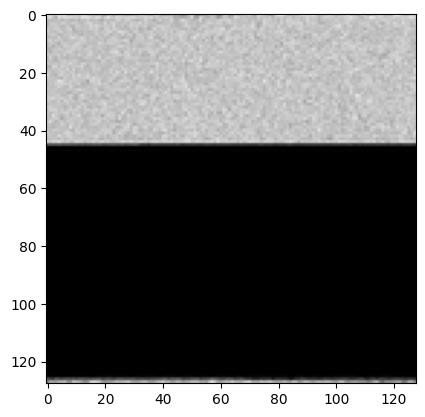

Label : [0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [9]:
img, label = next(iter(train_dataset))

plt.imshow(img[0], cmap='gray')
plt.show()

print(f"Label : {label[0]}")

# Simple CNN

In [10]:
def Simple_CNN():
    model = tf.keras.Sequential()
    model.add(Conv2D(50, (5,5), 
                             activation='relu', padding='same',
                             input_shape=(128, 128, 1)))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(70, (3,3), 
                             activation='relu', padding='same',
                             input_shape=(64, 64, 50)))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(70, (3,3), 
                             activation='relu', padding='same',
                             input_shape=(32, 32, 70)))
    model.add(MaxPooling2D((2,2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(9, activation='softmax'))
    
    adam = optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
malware_class = Simple_CNN()
malware_class.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 50)      1300      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 70)        31570     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 70)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 70)        44170     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 70)       0

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
save_path = './model/malware_cnn32/'
checkpoint_path = save_path+"/model_{epoch}.ckpt"

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, period=1)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)

In [ ]:
history = malware_class.fit(train_dataset, epochs=75, validation_data=val_dataset, callbacks=[cp_callback])

Epoch 1/75
34/34 [==============================] - 8s 145ms/step - loss: 1.4347 - accuracy: 0.5381 - val_loss: 0.9464 - val_accuracy: 0.6863
Epoch 2/75
34/34 [==============================] - 4s 105ms/step - loss: 0.7817 - accuracy: 0.7490 - val_loss: 0.6326 - val_accuracy: 0.7994
Epoch 3/75
34/34 [==============================] - 4s 104ms/step - loss: 0.5657 - accuracy: 0.8193 - val_loss: 0.4839 - val_accuracy: 0.8408
Epoch 4/75
34/34 [==============================] - 4s 104ms/step - loss: 0.4677 - accuracy: 0.8597 - val_loss: 0.4045 - val_accuracy: 0.9048
Epoch 5/75
34/34 [==============================] - 4s 105ms/step - loss: 0.3915 - accuracy: 0.8884 - val_loss: 0.3520 - val_accuracy: 0.9172
Epoch 6/75
34/34 [==============================] - 4s 105ms/step - loss: 0.3348 - accuracy: 0.9106 - val_loss: 0.3191 - val_accuracy: 0.9089
Epoch 7/75
34/34 [==============================] - 3s 103ms/step - loss: 0.2896 - accuracy: 0.9220 - val_loss: 0.2759 - val_accuracy: 0.9361
Epoch 

34/34 [==============================] - 4s 106ms/step - loss: 0.0132 - accuracy: 0.9975 - val_loss: 0.1440 - val_accuracy: 0.9770
Epoch 59/75
34/34 [==============================] - 4s 106ms/step - loss: 0.0113 - accuracy: 0.9974 - val_loss: 0.1543 - val_accuracy: 0.9775
Epoch 60/75
34/34 [==============================] - 4s 108ms/step - loss: 0.0123 - accuracy: 0.9974 - val_loss: 0.1496 - val_accuracy: 0.9784
Epoch 61/75
34/34 [==============================] - 4s 106ms/step - loss: 0.0114 - accuracy: 0.9977 - val_loss: 0.1450 - val_accuracy: 0.9765
Epoch 62/75
34/34 [==============================] - 4s 106ms/step - loss: 0.0116 - accuracy: 0.9976 - val_loss: 0.1516 - val_accuracy: 0.9775
Epoch 63/75
34/34 [==============================] - 4s 106ms/step - loss: 0.0135 - accuracy: 0.9967 - val_loss: 0.1622 - val_accuracy: 0.9761
Epoch 64/75
34/34 [==============================] - 4s 106ms/step - loss: 0.0131 - accuracy: 0.9972 - val_loss: 0.1483 - val_accuracy: 0.9742
Epoch 65/75

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

# Model Load and predict

In [ ]:
epoch = 30
checkpoint_path = f"./model/malware_cnn32/model_{epoch}.ckpt"

malware_class = Simple_CNN()
malware_class.load_weights(checkpoint_path)
malware_class.summary()

In [ ]:
loss, acc = malware_class.evaluate(val_dataset, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
imgs = glob("./dataset/img/img128/*.png")
img = tf.io.read_file(imgs[0])
img = tf.io.decode_image(img)
img = tf.expand_dims(img,axis=0)
img.shape

In [ ]:
prediction= malware_class.predict(img)
prediction